In [2]:
import numpy as np

# Define file paths for different g values
file_paths_force = {
    15: '../data/small_patch_platy/20241210/ciliate_15fil_5000blob_4.00R_0.0010torsion_0.0000tilt_0.3000f_eff_1.4960theta0_seg_forces.dat'
   }

# Read the .dat files into NumPy arrays and store them in a dictionary
data_dict_force = {g: np.loadtxt(path) for g, path in file_paths_force.items()}

forces = {}
for g, data in data_dict_force.items():
    downstream = np.array([data[:, i:i+3] for i in range(1, 121, 6)])
    upstream = np.array([data[:, i:i+3] for i in range(-6, -121, -6)])
    print(upstream.shape, downstream.shape)
    forces[g] = {'upstream': upstream, 'downstream': downstream}

(20, 101, 3) (20, 101, 3)


In [3]:
# Define file paths for different g values
file_paths_phase = {
    15: '../data/small_patch_platy/20241210/ciliate_15fil_5000blob_4.00R_0.0010torsion_0.0000tilt_0.3000f_eff_1.4960theta0_true_states.dat'
}

# Read the .dat files into NumPy arrays and store them in a dictionary
data_dict_phase = {g: np.loadtxt(path) for g, path in file_paths_phase.items()}

phases = {}
for g, data in data_dict_phase.items():
    downstream = np.mod(data[:, 2], 2*np.pi)
    upstream = np.mod(data[:, -1], 2*np.pi)
    print(upstream.shape, downstream.shape)
    phases[g] = {'upstream': upstream, 'downstream': downstream}

(101,) (101,)


In [4]:
# Define file paths for different g values
file_paths_vels = {
    15: '../data/small_patch_platy/20241210/ciliate_15fil_5000blob_4.00R_0.0010torsion_0.0000tilt_0.3000f_eff_1.4960theta0_seg_vels.dat'
}

# Read the .dat files into NumPy arrays and store them in a dictionary
data_dict_vels = {g: np.loadtxt(path) for g, path in file_paths_vels.items()}

velocities = {}
for g, data in data_dict_vels.items():
    downstream = np.array([data[:, i:i+3] for i in range(1, 121, 6)])
    upstream = np.array([data[:, i:i+3] for i in range(-6, -121, -6)])
    print(upstream.shape, downstream.shape)
    velocities[g] = {'upstream': upstream, 'downstream': downstream}

(20, 101, 3) (20, 101, 3)


In [5]:
# Initialize an empty dictionary to store the sum of dot products for each g value
viscous_dissipation_dict = {}
generalised_forces_dict = {}

# Iterate over each g value in the forces dictionary
for g in forces.keys():
    # Get the upstream and downstream forces and velocities for the current g value
    upstream_forces = forces[g]['upstream']
    downstream_forces = forces[g]['downstream']
    upstream_velocities = velocities[g]['upstream']
    downstream_velocities = velocities[g]['downstream']
    
    # Calculate the dot products for upstream and downstream
    upstream_dot_products = np.sum(np.einsum('ijk,ijk->ij', upstream_forces, upstream_velocities), axis=0)
    downstream_dot_products = np.sum(np.einsum('ijk,ijk->ij', downstream_forces, downstream_velocities), axis=0)

    print(upstream_dot_products.shape, downstream_dot_products.shape)

    
    while phases[g]['upstream'][0] > phases[g]['upstream'][-1]:
        phases[g]['upstream'] = np.roll(phases[g]['upstream'], -1)
        upstream_dot_products = np.roll(upstream_dot_products, -1)
    upstream_dot_products = np.roll(upstream_dot_products, 1)
    
    while phases[g]['downstream'][0] > phases[g]['downstream'][-1]:
        phases[g]['downstream'] = np.roll(phases[g]['downstream'], -1)
        downstream_dot_products = np.roll(downstream_dot_products, -1)
    
    viscous_dissipation_dict[g] = {'upstream': upstream_dot_products, 'downstream': downstream_dot_products}
    generalised_forces_dict[g] = {'upstream': upstream_dot_products/2/np.pi, 'downstream': downstream_dot_products/2/np.pi}

(101,) (101,)


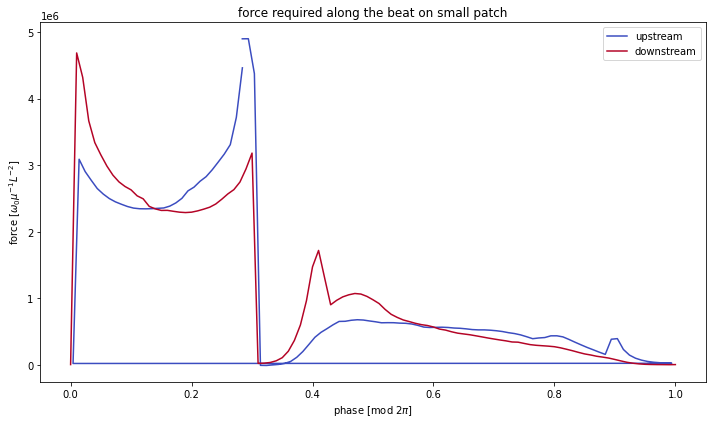

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 20})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize the color map based on the gap sizes
norm = plt.Normalize(-max(generalised_forces_dict.keys())/2, max(generalised_forces_dict.keys())/2)

# Plot the data for each gap size
for g in sorted(generalised_forces_dict.keys(), reverse=True):

    # Get the color for the current gap size
    color_upstream = cm.coolwarm(norm(-g/2))
    color_downstream = cm.coolwarm(norm(g/2))
    alpha = 1.0
    
    # Plot upstream data
    ax.plot(phases[g]['upstream']/2/np.pi, generalised_forces_dict[g]['upstream'], color=color_upstream, alpha=alpha, label='upstream')
    
    # Plot downstream data
    ax.plot(phases[g]['downstream']/2/np.pi, generalised_forces_dict[g]['downstream'], color=color_downstream, alpha=alpha, label='downstream')

# Add labels and title
ax.set_xlabel(r'phase [$\mathrm{mod}\;2\pi$]')
ax.set_ylabel('force [$\omega_0 \mu^{-1} L^{-2}$]')
ax.set_title(r'force required along the beat on small patch')

# Create a color bar
# sm = plt.cm.ScalarMappable(cmap=cm.RdBu, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label(r'Relative position [$\mu\mathrm{m}$]')

# Add legend
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

plt.savefig('generalised_forces.pdf')


In [7]:
# Initialize dictionaries to store the total viscous dissipation for each gap size
total_viscous_dissipation_upstream = {}
total_viscous_dissipation_downstream = {}

# Normalize the color map based on the gap sizes
norm = plt.Normalize(-max(generalised_forces_dict.keys())/2, max(generalised_forces_dict.keys())/2)

# Iterate over each gap size in the viscous_dissipation_dict
for g in viscous_dissipation_dict.keys():
    if g < 30:
        # Sum all values of viscous dissipation for upstream and downstream
        total_viscous_dissipation_upstream[g] = np.sum(viscous_dissipation_dict[g]['upstream'])
        total_viscous_dissipation_downstream[g] = np.sum(viscous_dissipation_dict[g]['downstream'])

# Convert the dictionaries to lists of tuples and sort them by gap size
sorted_upstream = sorted(total_viscous_dissipation_upstream.items())
sorted_downstream = sorted(total_viscous_dissipation_downstream.items())

# Extract the gap sizes and total viscous dissipation values
gap_sizes_upstream, total_dissipation_upstream = zip(*sorted_upstream)
gap_sizes_downstream, total_dissipation_downstream = zip(*sorted_downstream)

total_dissipation_downstream

(717613385.1588924,)

In [9]:
total_dissipation_upstream

(740786768.0030266,)

In [10]:
# Initialize a dictionary to store the percentage difference for each gap size
percentage_difference = {}

# Iterate over each gap size in the viscous_dissipation_dict
for g in viscous_dissipation_dict.keys():
    if g < 30:
        # Calculate the percentage difference
        upstream_dissipation = total_viscous_dissipation_upstream[g]
        downstream_dissipation = total_viscous_dissipation_downstream[g]
        percentage_difference[g] = ((downstream_dissipation - upstream_dissipation) / upstream_dissipation) * 100

# Convert the dictionary to a list of tuples and sort them by gap size
sorted_percentage_difference = sorted(percentage_difference.items())

# Extract the gap sizes and percentage difference values
gap_sizes, percentage_diff_values = zip(*sorted_percentage_difference)

percentage_diff_values


(-3.128212306842869,)